In [1]:
import os

# os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex

Audited 6 packages in 80ms


# Imports


In [3]:
import random
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import requests
import torch
import torchvision
import torchvision.models as models
from mlxtend.plotting import plot_confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from skorch import NeuralNetClassifier
from torch import nn
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from sklearnex import patch_sklearn
import warnings

os.mkdir("reports_FashionMNIST")
patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

mlxtend version: 0.23.1
torch 2.1.0+cu121
torchvision 0.16.0+cu121
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# FashionMNIST


In [4]:
FashionMNIST_train_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


FashionMNIST_test_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)



x_train, y_train = FashionMNIST_train_data.data, np.array(
    FashionMNIST_train_data.targets
)


x_test, y_test = FashionMNIST_test_data.data, np.array(FashionMNIST_test_data.targets)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]), (60000,), torch.Size([10000, 28, 28]), (10000,))

In [7]:
FashionMNIST_class_names = FashionMNIST_train_data.classes
print(FashionMNIST_class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
num_classes = len(FashionMNIST_class_names)
num_classes

10

In [9]:
class_to_idx_cif = FashionMNIST_train_data.class_to_idx
print(class_to_idx_cif)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


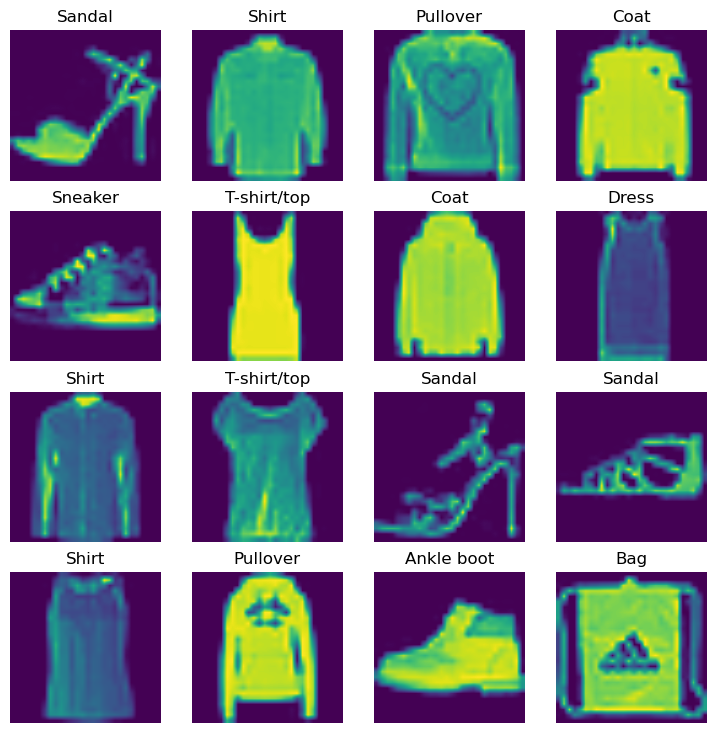

In [10]:
# Show more images
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(FashionMNIST_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = FashionMNIST_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(FashionMNIST_class_names[label])
    plt.axis(False)

plt.savefig("reports_FashionMNIST/FashionMNIST_imgs_labeled.png")
plt.show()

# Unlabeling The Dataset


In [11]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(
    len(FashionMNIST_train_data) * percentage_without_labels
)
num_samples_with_labels = len(FashionMNIST_train_data) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(FashionMNIST_train_data)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(FashionMNIST_train_data)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [12]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

(torch.Size([12000, 28, 28]), (12000,), torch.Size([48000, 28, 28]), (48000,))

In [13]:
x_initial.unsqueeze(1).repeat(1, 3, 1, 1).shape

torch.Size([12000, 3, 28, 28])

In [14]:
len(FashionMNIST_train_data)

60000

In [15]:
FashionMNIST_train_data[1][1]

0

# Creating the DataLoaders


In [16]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(x, dtype=torch.float32).unsqueeze(1).repeat(1, 3, 1, 1),
        torch.tensor(y),
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
BATCH_SIZE_CIF = 32

FashionMNIST_train_data_loader = numpy_to_dataloader(
    x_initial, y_initial, BATCH_SIZE_CIF
)
FashionMNIST_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [18]:
FashionMNIST_train_data_loader, FashionMNIST_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x16f0dbde650>,
 <torch.utils.data.dataloader.DataLoader at 0x16f0dc3d2d0>)

In [19]:
print(
    f"Length of Training Data loader: {len(FashionMNIST_train_data_loader)}, Batches of {FashionMNIST_train_data_loader.batch_size}"
)
print(
    f"Length of Testing Data loader: {len(FashionMNIST_test_data_loader)}, Batches of {FashionMNIST_test_data_loader.batch_size}"
)

Length of Training Data loader: 375, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Importing and Using ResNet 50 Architecture


In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [21]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

device(type='cpu')

In [22]:
f = nn.Flatten(start_dim=0)  # The default start dim is 1
x = f(torch.randn(10, 7, 7))
x.size()

torch.Size([490])

In [23]:
rand_image_tensor = torch.randn(size=(32, 3, 28, 28))

In [24]:
rand_image_tensor.device

device(type='cpu')

In [25]:
model(rand_image_tensor)

tensor([[ 2.3437e-01, -1.0068e-02, -5.3400e-02,  1.4267e-01,  7.7863e-02,
         -6.9469e-02,  3.8334e-01, -7.7549e-03, -3.4844e-02, -1.0168e-02],
        [-4.4449e-01, -8.1069e-01, -1.2570e-01,  1.8966e-01,  1.0145e-01,
          5.0834e-01,  8.1421e-01, -5.0558e-01, -7.6514e-02, -1.8284e-01],
        [-2.8723e-01,  2.9258e-02, -3.3570e-01, -8.7047e-02,  4.3215e-01,
          3.3450e-01, -2.0087e-01, -1.8113e-01,  2.0618e-01, -3.2081e-01],
        [ 2.7517e-01, -3.5627e-01,  9.5362e-01,  4.0246e-01,  2.8488e-01,
          2.2842e-01,  3.0545e-01,  7.8752e-01, -6.9493e-01, -1.7582e-01],
        [-6.2412e-02,  1.0116e-01,  4.3442e-01, -3.9902e-02, -3.0589e-01,
          1.9683e-01, -7.2727e-02,  1.8635e-02,  1.4850e-01, -7.2438e-02],
        [ 5.8647e-01, -2.5229e-01,  7.0862e-02,  2.7759e-01, -2.3636e-01,
          4.0576e-02,  1.0058e-01,  5.0469e-01, -9.4187e-02, -2.2448e-01],
        [ 7.8428e-01, -1.8010e-01, -2.4101e-01,  5.2063e-01,  5.7317e-01,
         -7.7953e-01,  9.5012e-0

In [26]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

# Printing the Architecture and Number of Trianing Parameters in each Layer


In [27]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# External Helper Functions


In [28]:
if Path("HelperFunctions.py").is_file():
    print("Helper Functions already exists, skipping downloading")
else:
    print("downloading HelperFunctions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("HelperFunctions.py", "wb") as f:
        f.write(request.content)

Helper Functions already exists, skipping downloading


In [29]:
# Picking a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [30]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = correct / len(y_true) * 100
    return accuracy

In [31]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

In [32]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


1.5700003132224083e-05

In [33]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    training_loss = 0
    training_acc = 0
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        # Put the data on the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        y_pred = model(x)
        # Loss
        loss = loss_fn(y_pred, y)
        training_loss += loss
        training_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # optimizer step step step
        optimizer.step()
    # After looping over batches, divide the training loss over the number of batches to get the average loss per batch
    training_loss /= len(
        data_loader
    )  # train.data_loader (returns the number of batches)
    training_acc /= len(data_loader)
    print(
        f"Training Loss: {training_loss:.5f} | Training Accuracy: {training_acc:.2f}%"
    )
    return training_acc, training_loss

In [34]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    testing_acc = 0
    testing_loss = 0
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_test_pred = model(x)
            # Loss
            testing_loss += loss_fn(y_test_pred, y)
            # Accuracy
            testing_acc += accuracy_fn(y_test_pred.argmax(dim=1), y)
        testing_loss /= len(data_loader)
        testing_acc /= len(data_loader)
    print(f"Testing Loss: {testing_loss:.3f} | Testing Accuracy: {testing_acc:.2f}%")
    return testing_acc, testing_loss

In [35]:
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=num_classes)
recall = Recall(task="multiclass", num_classes=num_classes)
f1 = F1Score(task="multiclass", num_classes=num_classes)
confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Base Model Training


In [36]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start_time_on_gpu = timer()
# Set the number of epochs
epochs = 10
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []
# Training
for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    # Training
    ACC_TRAIN, LOSS_TRAIN = train_step(
        model, FashionMNIST_train_data_loader, loss_fn, optimizer, accuracy_fn, device
    )
    # Testing
    ACC_TEST, LOSS_TEST = test_step(
        model, FashionMNIST_test_data_loader, loss_fn, accuracy_fn, device
    )
    # y_preds
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(FashionMNIST_test_data_loader, desc="Making Predictions..."):
            # Send the data to the target device
            x, y = x.to(device), y.to(device)
            # Forward Pass
            logits = model(x)
            # Pred probs then labels
            y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
            # Put predictions on the cpu for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate the predicions of all batches
    y_pred_tensor = torch.cat(y_preds)
    # Update the metrics with true and predicted labels
    precision.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    recall.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    f1.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    # List
    acc_TRAIN.append(ACC_TRAIN)
    acc_TEST.append(ACC_TEST)
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(precision.compute())
    recall_result.append(recall.compute())
    f1_result.append(f1.compute())

# Compute the time of the training
print("\nTraining is finished!\n")
train_end_time_on_gpu = timer()
display_train_time(
    train_start_time_on_gpu,
    train_end_time_on_gpu,
    device=next(model.parameters()).device,
)

  0%|          | 0/10 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training Loss: 1.40179 | Training Accuracy: 60.86%
Testing Loss: 0.836 | Testing Accuracy: 70.41%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 2
--------------------------------------
Training Loss: 0.70101 | Training Accuracy: 75.47%
Testing Loss: 0.668 | Testing Accuracy: 75.67%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 3
--------------------------------------
Training Loss: 0.63467 | Training Accuracy: 77.06%
Testing Loss: 0.651 | Testing Accuracy: 76.76%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 4
--------------------------------------
Training Loss: 0.52024 | Training Accuracy: 80.93%
Testing Loss: 0.541 | Testing Accuracy: 79.60%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 5
--------------------------------------
Training Loss: 0.48532 | Training Accuracy: 82.00%
Testing Loss: 0.546 | Testing Accuracy: 81.21%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 6
--------------------------------------
Training Loss: 0.43845 | Training Accuracy: 83.79%
Testing Loss: 0.463 | Testing Accuracy: 83.24%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 7
--------------------------------------
Training Loss: 0.41997 | Training Accuracy: 84.35%
Testing Loss: 0.451 | Testing Accuracy: 83.17%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 8
--------------------------------------
Training Loss: 0.39297 | Training Accuracy: 85.58%
Testing Loss: 0.421 | Testing Accuracy: 84.55%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 9
--------------------------------------
Training Loss: 0.37914 | Training Accuracy: 85.80%
Testing Loss: 0.435 | Testing Accuracy: 83.65%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 10
--------------------------------------
Training Loss: 0.36726 | Training Accuracy: 86.65%
Testing Loss: 0.427 | Testing Accuracy: 85.22%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


Training is finished!

Train time on device cuda:0: 186.743 seconds


186.74258200000622

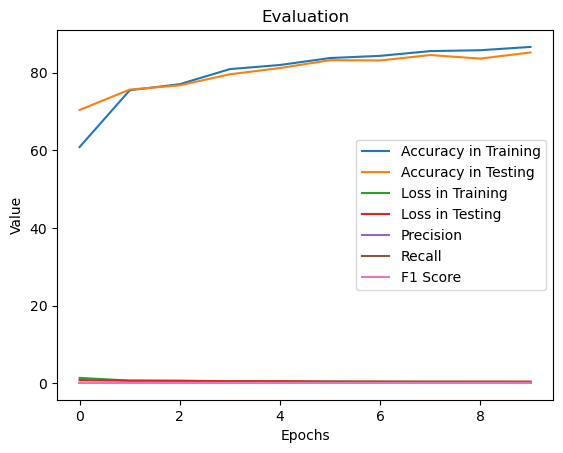

Precision: 0.10057999938726425
Recall: 0.10057999938726425
F1 Score: 0.10057999938726425


In [37]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")
# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/evals_base_model_before_al.png")
plt.show()
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [38]:
torch.manual_seed(42)

In [39]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    model.eval()
    loss, acc = 0, 0

    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_pred = model(x)
            # Loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(torch.argmax(y_pred, dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
    }, torch.argmax(y_pred, dim=1)

In [40]:
# Testing the model
FashionMNIST_model_results, y_pred = eval_model(
    model, FashionMNIST_test_data_loader, loss_fn, accuracy_fn
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [41]:
FashionMNIST_model_results

{'Model Name': 'ResNet',
 'Model Loss': 0.4271620810031891,
 'Model Accuracy': 85.19369009584665}

In [42]:
len(next(iter(FashionMNIST_test_data_loader)))

2

# Evaluating Model Visually


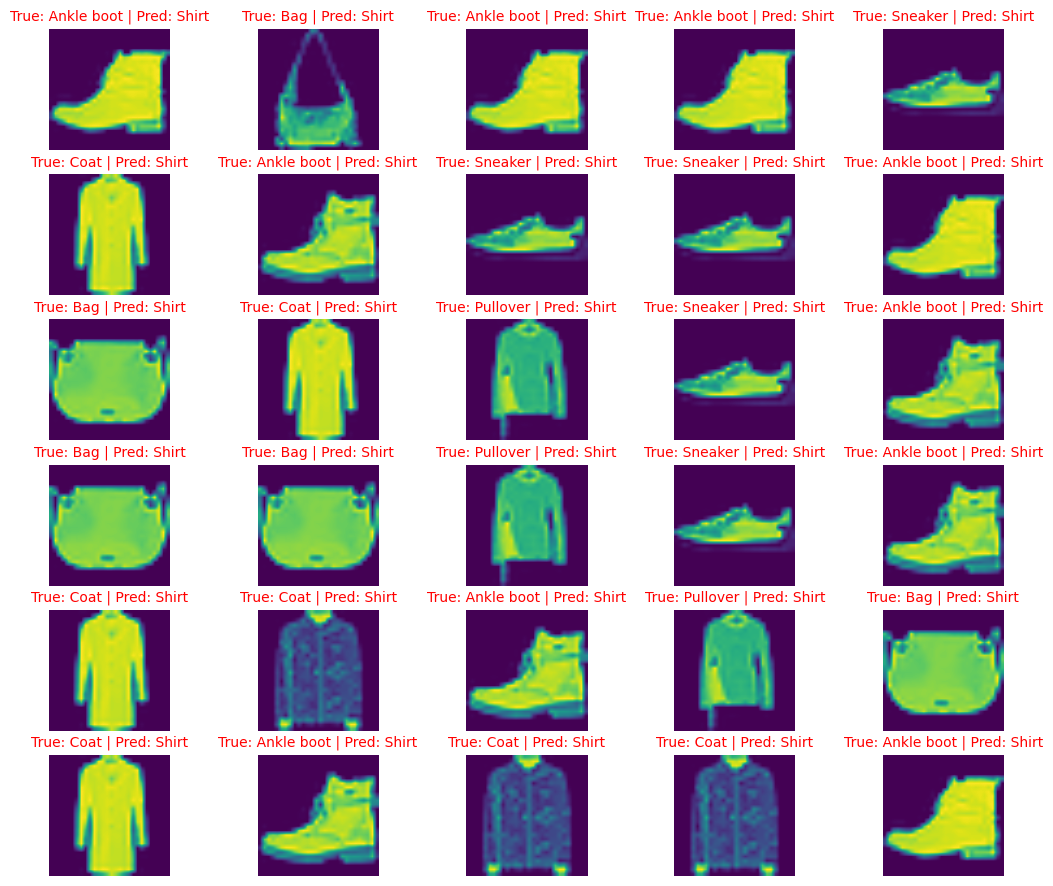

In [43]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(FashionMNIST_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, interpolation="bilinear")
        if pred_label == label:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="g",
                fontsize=10,
            )
        else:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="r",
                fontsize=10,
            )
        plt.axis(False)
plt.savefig("reports_FashionMNIST/preds_base_model_before_al.png")

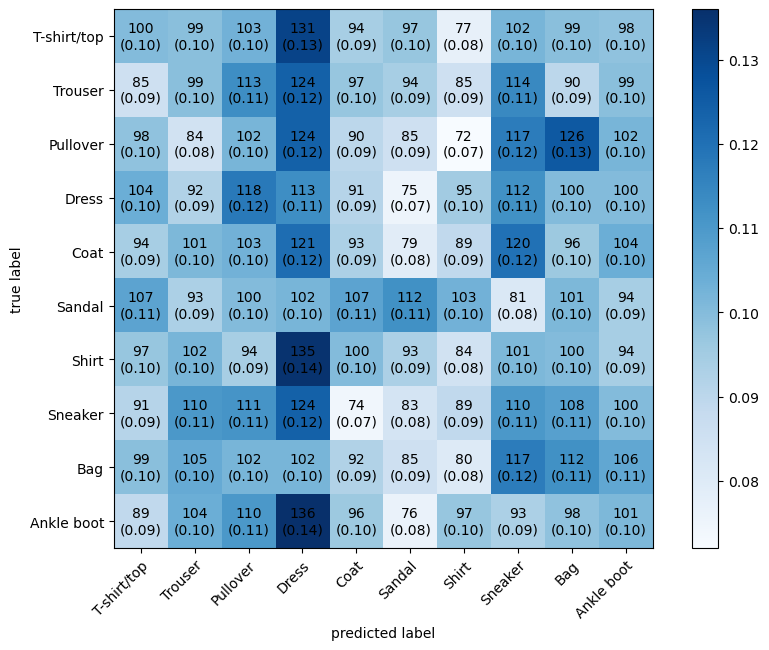

In [44]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(FashionMNIST_class_names))
confmat_tensor = confmat(
    preds=y_pred_tensor, target=torch.tensor(FashionMNIST_test_data.targets)
)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=FashionMNIST_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)
plt.savefig("reports_FashionMNIST/conf_mat_base_model_before_al.png")

# Saving the Model


In [45]:
# Create the models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
# Create model save
MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME
# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\base_model.pth


# Load the Model


In [46]:
# Create a model instance
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [48]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=1,
    device=device,
)

# Active Learning


In [49]:
def active_learning(
    pool_x,
    pool_y,
    initial_x,
    initial_y,
    test_x,
    test_y,
    method,
    model,
    num_classes,
    class_names,
):
    learner = None
    cycles = 10
    acc = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":

        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(
                range(n_samples), size=n_instances, replace=False
            )
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=random_sampling,
        )
    else:
        print("Invalid Input")
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, query_instance = learner.query(pool_x, n_instances=1)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        # remove queried instance from pool_x
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(
            np.concatenate((initial_x, pool_x), axis=0),
            np.concatenate((initial_y, pool_y), axis=0),
        )
        print(f"Accuracy after query {cycle+1}: {model_accuracy:0.4f}")
        acc.append(model_accuracy)

        y_pred = learner.predict(test_x)
        # Initialize precision, recall, and F1 score metrics
        precision = Precision(task="multiclass", num_classes=num_classes)
        recall = Recall(task="multiclass", num_classes=num_classes)
        f1 = F1Score(task="multiclass", num_classes=num_classes)
        # Update the metrics with true and predicted labels
        precision.update(torch.tensor(y_pred), torch.tensor(test_y))
        recall.update(torch.tensor(y_pred), torch.tensor(test_y))
        f1.update(torch.tensor(y_pred), torch.tensor(test_y))
        # Compute the metrics
        precision_result.append(precision.compute())
        recall_result.append(recall.compute())
        f1_result.append(f1.compute())

    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    confusion_matrix.update(torch.tensor(y_pred), torch.tensor(test_y))
    fig, ax = plot_confusion_matrix(
        conf_mat=confusion_matrix.compute().numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports_FashionMNIST/conf_mat_{method}_after_al.png")
    return acc, precision_result, recall_result, f1_result

In [50]:
x_pool = x_pool.unsqueeze(1).repeat(1, 3, 1, 1)
x_initial = x_initial.unsqueeze(1).repeat(1, 3, 1, 1)
x_test = x_test.unsqueeze(1).repeat(1, 3, 1, 1)

x_pool = x_pool.numpy()
x_initial = x_initial.numpy()
x_test = x_test.numpy()

x_pool = x_pool.astype(np.float32)
x_initial = x_initial.astype(np.float32)
x_test = x_test.astype(np.float32)

In [51]:
x_pool.shape, x_initial.shape, x_test.shape

((48000, 3, 28, 28), (12000, 3, 28, 28), (10000, 3, 28, 28))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.3276  6.2889
      2        0.2860  6.0558
      3        0.3264  6.0760
      4        0.3267  6.0749
      5        0.2526  6.1624
      6        0.2264  6.1047
      7        0.2131  6.1816
      8        0.1968  6.0481
      9        0.2491  6.0496
     10        0.2043  6.0155
Starting Active Learning with random_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2016  6.1014
      2        0.1808  6.0256
      3        0.1644  6.0259
      4        0.1606  6.0413
      5        0.1589  6.0120
      6        0.1626  6.0253
      7        0.1398  5.9922
      8        0.1317  6.0224
      9        0.1371  6.0070
     10        0.1166  6.0355
Accuracy after query 1: 0.8679

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.1458  6.0814
      2        0.1515  6.0246
  

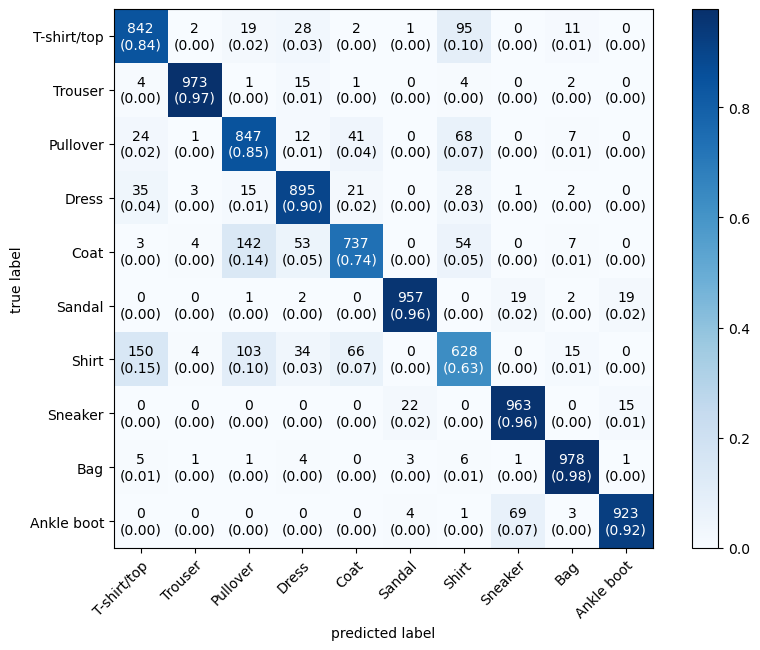

In [52]:
(
    acc_random_sampling,
    precision_result_random_sampling,
    recall_result_random_sampling,
    f1_result_random_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "random_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0324  6.0586
      2        0.0395  6.0327
      3        0.0237  6.0401
      4        0.0293  5.9919
      5        0.0218  6.0048
      6        0.0143  6.0021
      7        0.0121  6.0243
      8        0.0206  6.0057
      9        0.0274  6.0426
     10        0.0415  6.0517
Starting Active Learning with uncertainty_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0306  6.0181
      2        0.0587  6.0399
      3        0.0229  6.0245
      4        0.0084  6.0585
      5        0.0032  5.9801
      6        0.0056  6.0182
      7        0.0052  6.0198
      8        0.0201  6.0126
      9        0.0222  6.0386
     10        0.0266  6.0254
Accuracy after query 1: 0.9034

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0342  6.0070


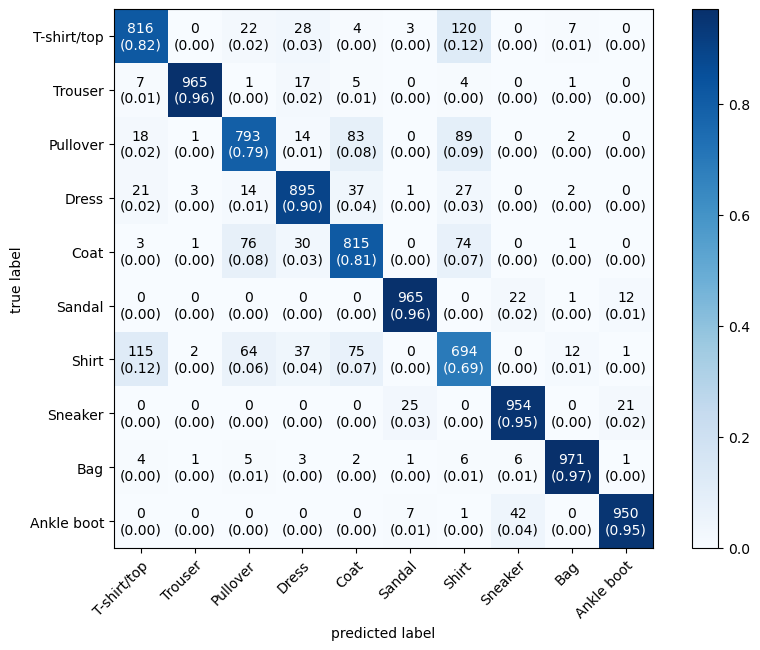

In [53]:
(
    acc_uncertainty_sampling,
    precision_result_uncertainty_sampling,
    recall_result_uncertainty_sampling,
    f1_result_uncertainty_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "uncertainty_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0269  6.0364
      2        0.0205  6.0360
      3        0.0095  5.9956
      4        0.0146  5.9987
      5        0.0087  5.9945
      6        0.0055  6.0063
      7        0.0163  5.9802
      8        0.0183  5.9951
      9        0.0122  6.0188
     10        0.0205  6.0183
Starting Active Learning with margin_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0208  6.0118
      2        0.0135  6.0222
      3        0.0067  5.9905
      4        0.0059  5.9892
      5        0.0042  6.0097
      6        0.0100  6.0106
      7        0.0127  5.9654
      8        0.0386  6.0849
      9        0.0316  5.9733
     10        0.0303  6.0061
Accuracy after query 1: 0.9050

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0150  6.0052
     

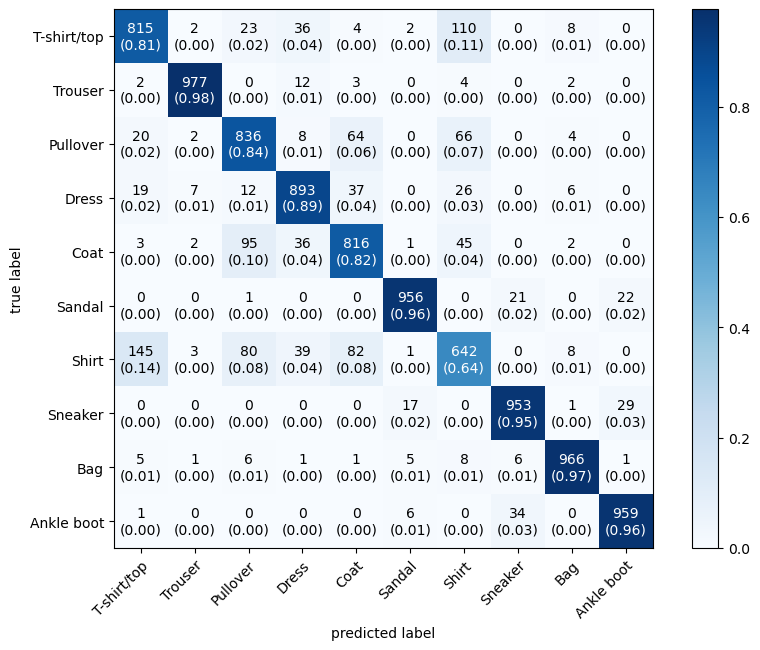

In [54]:
(
    acc_margin_sampling,
    precision_result_margin_sampling,
    recall_result_margin_sampling,
    f1_result_margin_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "margin_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0133  6.0786
      2        0.0180  6.0448
      3        0.0153  5.9949
      4        0.0121  5.9846
      5        0.0026  6.0136
      6        0.0002  6.0206
      7        0.0001  6.0187
      8        0.0000  6.0033
      9        0.0000  6.0176
     10        0.0000  6.0036
Starting Active Learning with entropy_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0081  6.0613
      2        0.0132  6.1068
      3        0.0294  6.0257
      4        0.0121  6.0197
      5        0.0063  5.9925
      6        0.0007  6.0008
      7        0.0001  6.0213
      8        0.0000  6.0167
      9        0.0000  6.0338
     10        0.0000  6.1054
Accuracy after query 1: 0.9094

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0111  6.0290
    

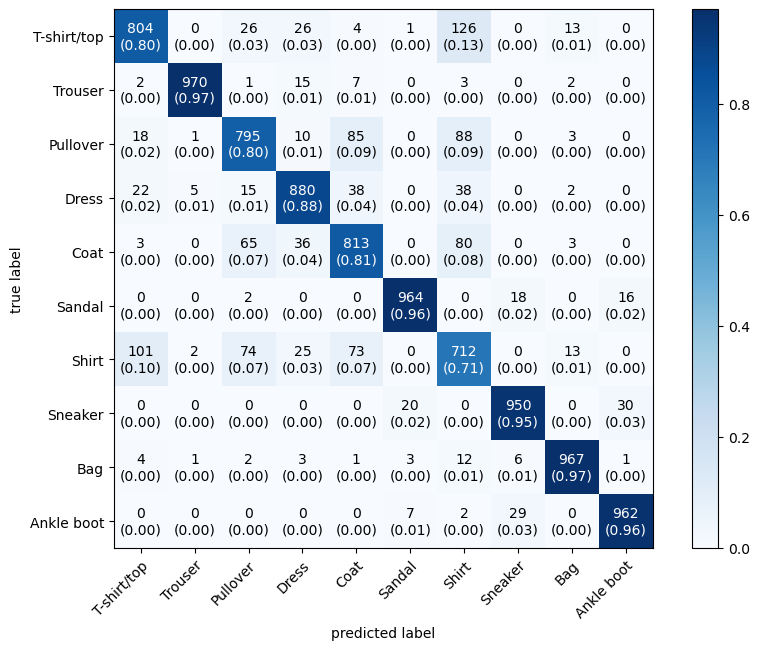

In [55]:
(
    acc_entropy_sampling,
    precision_result_entropy_sampling,
    recall_result_entropy_sampling,
    f1_result_entropy_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "entropy_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

# Plot All Metrics


# Accuracy


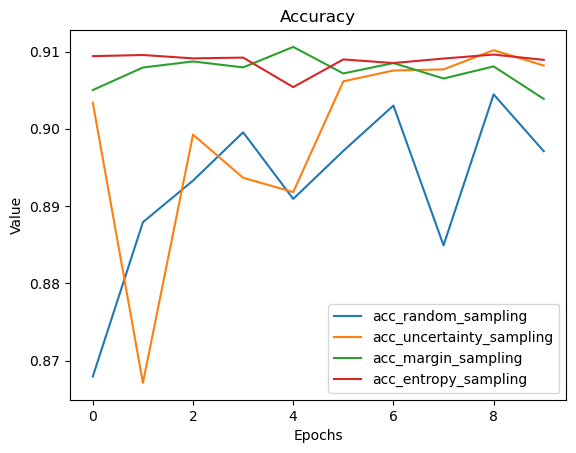

acc_random_sampling: 0.8970995165860977
acc_uncertainty_sampling: 0.908184697449575
acc_margin_sampling: 0.9038673112185365
acc_entropy_sampling: 0.9089181530255043


In [56]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(acc_uncertainty_sampling, label="acc_uncertainty_sampling")
plt.plot(acc_margin_sampling, label="acc_margin_sampling")
plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/acc_base_model_after_al.png")
plt.show()

print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"acc_uncertainty_sampling: {acc_uncertainty_sampling[-1]}")
print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

# Precision


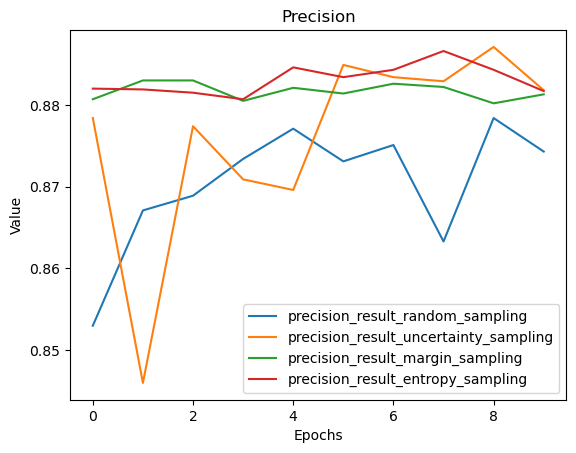

precision_result_random_sampling: 0.8743000030517578
precision_result_uncertainty_sampling: 0.8817999958992004
precision_result_margin_sampling: 0.8812999725341797
precision_result_entropy_sampling: 0.8816999793052673


In [57]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(
    precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling"
)
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/prec_base_model_after_al.png")
plt.show()

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(
    f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}"
)
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

# Recall


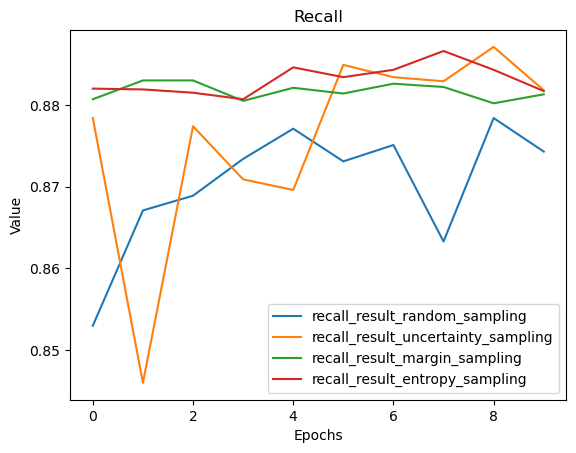

recall_result_random_sampling: 0.8743000030517578
recall_result_uncertainty_sampling: 0.8817999958992004
recall_result_margin_sampling: 0.8812999725341797
recall_result_entropy_sampling: 0.8816999793052673


In [58]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/recall_base_model_after_al.png")
plt.show()

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

# F1 Score


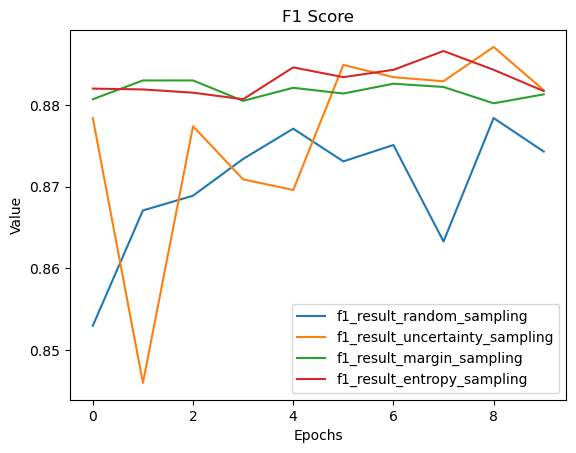

f1_result_random_sampling: 0.8743000030517578
f1_result_uncertainty_sampling: 0.8817999958992004
f1_result_margin_sampling: 0.8812999725341797
f1_result_entropy_sampling: 0.8816999793052673


In [59]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/f1_base_model_after_al.png")
plt.show()

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")